In [1204]:
import pandas as pd

In [1205]:
songs_dataset = pd.read_json('MasterSongList.json')

In [1206]:
#checking
#songs_dataset.head(10)

In [1207]:
songs_dataset.loc[:, 'genres'] = songs_dataset['genres'].apply(''.join)

def consolidateGenre(genre):
    if (len(genre) > 0):
        return genre.split(':')[0]
    else:
        return genre
    
songs_dataset.loc[:, 'genres'] = songs_dataset['genres'].apply(consolidateGenre)

In [1208]:
#songs_dataset.head(10)

In [1209]:
#songs_dataset.head(1).to_dict()

In [1210]:
jazz_df = songs_dataset[(songs_dataset['genres'] == 'jazz') & (songs_dataset['yt_views'] > 1000)]
print(jazz_df.shape)
dance_df = songs_dataset[(songs_dataset['genres'] == 'dance') & (songs_dataset['yt_views'] > 1000)]
print(dance_df.shape)
rock_df = songs_dataset[(songs_dataset['genres'] == 'rock') & (songs_dataset['yt_views'] > 1000)]
print(rock_df.shape)
rap_df = songs_dataset[(songs_dataset['genres'] == 'rap') & (songs_dataset['yt_views'] > 1000)]
print(rap_df.shape)

(1973, 16)
(2285, 16)
(7174, 16)
(2855, 16)


In [1211]:
#consolidating jazz audio features

jazz_df = songs_dataset[(songs_dataset['genres'] == 'jazz') & (songs_dataset['yt_views'] > 1000)]
print(jazz_df.shape) #1973 rows

jazzAFL = [] #AFL - audio_feature_list
for audio_feature in jazz_df['audio_features']:
    jazzAFL.append(audio_feature)

audio_feature_headers = ['key', 'energy', 'liveliness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'time_signature', 'duration', 'loudness', 'valence', 'danceability', 'mode', 'time_signature_confidence', 'tempo_confidence', 'key_confidence', 'mode_confidence']

jazz_AF = pd.DataFrame(jazzAFL, columns=audio_feature_headers).dropna() #AF - audio_features
print(jazz_AF.dropna().shape) #1677 rows of jazz


(1973, 16)
(1677, 17)


In [1212]:
jazz_AF['genres'] = jazz_df['genres']
jazz_AF['genres'].fillna(value='jazz', inplace=True)

In [1213]:
#consolidating dance audio features
dance_df = songs_dataset[(songs_dataset['genres'] == 'dance') & (songs_dataset['yt_views'] > 1000)]
print(dance_df.shape)

danceAFL = []
for audio_feature in dance_df['audio_features']:
    danceAFL.append(audio_feature)
    
dance_AF = pd.DataFrame(danceAFL, columns=audio_feature_headers).dropna()
print(dance_AF.shape) #1938 rows of dance

(2285, 16)
(1938, 17)


In [1214]:
dance_AF['genres'] = dance_df['genres']
dance_AF['genres'].fillna(value='dance', inplace=True)

In [1215]:
#consolidating rock audio features

rock_df = songs_dataset[(songs_dataset['genres'] == 'rock') & (songs_dataset['yt_views'] > 1000)]
print(rock_df.shape)

rockAFL = []
for audio_feature in rock_df['audio_features']:
    rockAFL.append(audio_feature)
    
rock_AF = pd.DataFrame(rockAFL, columns=audio_feature_headers).dropna()
print(rock_AF.shape) #6245 rock songs

(7174, 16)
(6245, 17)


In [1216]:
rock_AF['genres'] = rock_df['genres'] #adding genre column
rock_AF['genres'].fillna(value='rock', inplace=True) 

In [1217]:
# consolidating rap audio features
rap_df = songs_dataset[(songs_dataset['genres'] == 'rap') & (songs_dataset['yt_views'] > 1000)]
print(rap_df.shape)

rapAFL = []
for audio_feature in rap_df['audio_features']:
    rapAFL.append(audio_feature)
    
rap_AF = pd.DataFrame(rapAFL, columns=audio_feature_headers).dropna()
print(rap_AF.shape) #2411 rap songs

(2855, 16)
(2411, 17)


In [1218]:
rap_AF['genres'] = rap_df['genres'] #when i do this, many go NaN
rap_AF['genres'].fillna(value='rap', inplace=True)
#rap_AF

## Consolidating & Balancing

In [1219]:
#using below as guide
#rap_df_features2 = df_features2[df_features2['genres'] == 'rap'].sample(n=1075, replace=True)
#consolidatedRapCountry = consolidatedRapCountry[(songs_dataset['genres'] == 'rap') | (songs_dataset['genres'] == 'country')]
#jazz_features.fillna(anime_dataset['rating'].median(), inplace=True)

In [1220]:
#consolidating all the features picking 1500 from each
consolidatedSongFeatures = pd.concat((jazz_AF.sample(n=1500, replace=True), dance_AF.sample(n=1500, replace=True), rock_AF.sample(n=1500, replace=True), rap_AF.sample(n=1500, replace=True)), axis=0)
consolidatedSongFeatures.shape
#consolidatedSongFeatures

(6000, 18)

In [1221]:
df_labels = consolidatedSongFeatures['genres']
df_features = consolidatedSongFeatures.drop('genres', axis=1)
#df_features

In [1222]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
df_features_final = standard_scaler.fit_transform(df_features)

# Train Test Split

In [1223]:
from sklearn.cross_validation import train_test_split
X = df_features_final
y = df_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


# Support Vector Machine

In [1224]:
from sklearn.svm import SVC

In [1225]:
svc_original = SVC(C=1, gamma=1)

In [1226]:
svc_original.fit(X_train, y_train)
svc_predictions = svc_original.predict(X_test)

In [1227]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, svc_predictions))
print(classification_report(list(y_test), list(svc_predictions)))

[[270   0  15 152]
 [  4 229   1 221]
 [ 10   0 292 153]
 [ 19   5   4 425]]
             precision    recall  f1-score   support

      dance       0.89      0.62      0.73       437
       jazz       0.98      0.50      0.66       455
        rap       0.94      0.64      0.76       455
       rock       0.45      0.94      0.61       453

avg / total       0.81      0.68      0.69      1800



### SVM - GridSearchCV

In [1228]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10], 'gamma': [1,0.1,0.01,0.001]}


In [1229]:
grid = GridSearchCV(svc_original, param_grid, verbose=3)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] C=0.1, gamma=1 ..................................................
[CV] ........ C=0.1, gamma=1, score=0.25320970042796004, total=   0.5s
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] ........ C=0.1, gamma=1, score=0.25303788420300216, total=   0.5s
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] ........ C=0.1, gamma=1, score=0.25303788420300216, total=   0.5s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ....... C=0.1, gamma=0.1, score=0.7617689015691869, total=   0.3s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ....... C=0.1, gamma=0.1, score=0.7405289492494639, total=   0.3s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ....... C=0.1, gamma=0.1, score=0.7619728377412437, total=   0.3s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ...... C=0.1, gamma=0.01, score=0.7738944365192582, total=   0.3s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ...... C=0.1, gamma=0.01, score=0.7355253752680486, total=   0.3s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ...... C=0.1, gamma=0.01, score=0.7605432451751251, total=   0.3s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   19.7s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [1230]:
grid.best_params_

{'C': 10, 'gamma': 0.1}

### Note: Make sure SVC has same C & gamma

In [1231]:
svc_best = SVC(C=10, gamma=0.1)
svc_best.fit(X_train, y_train)
svc_predictions = svc_best.predict(X_test)
print(confusion_matrix(y_test, svc_predictions))
print(classification_report(list(y_test), list(svc_predictions)))

[[349  11  47  30]
 [  5 409   4  37]
 [ 36  15 389  15]
 [ 38  47  12 356]]
             precision    recall  f1-score   support

      dance       0.82      0.80      0.81       437
       jazz       0.85      0.90      0.87       455
        rap       0.86      0.85      0.86       455
       rock       0.81      0.79      0.80       453

avg / total       0.83      0.83      0.83      1800



## SVM - Select K Best

In [1232]:
from sklearn.feature_selection import SelectKBest
selector = SelectKBest(k=5)
X_new = selector.fit_transform(X, y)

In [1233]:
X_new.shape

(6000, 5)

In [1234]:
df_features.columns[selector.get_support(indices=True)].tolist()

['energy', 'speechiness', 'acousticness', 'valence', 'mode']

In [1235]:
X = X_new
y = df_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [1236]:
svc_optimized = SVC(C=1, gamma=0.1)
svc_optimized.fit(X_train, y_train)
svc_predictions = svc_optimized.predict(X_test)
print(confusion_matrix(y_test, svc_predictions))
print(classification_report(list(y_test), list(svc_predictions)))

[[283  15  75  64]
 [ 17 390   9  39]
 [ 85  18 333  19]
 [ 54  84  10 305]]
             precision    recall  f1-score   support

      dance       0.64      0.65      0.65       437
       jazz       0.77      0.86      0.81       455
        rap       0.78      0.73      0.76       455
       rock       0.71      0.67      0.69       453

avg / total       0.73      0.73      0.73      1800



## Analysis:
`svc_optimized` with the 5 best features is less accurate than `svc_best`, because more than 5 features is needed. 

# Random Forest Classifier

In [1237]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [1238]:
from numpy import sort
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

In [1239]:
X = df_features_final
y = df_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

In [1240]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4200, 17)
(1800, 17)
(4200,)
(1800,)


In [1241]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc_original = RandomForestClassifier(n_estimators=5, min_samples_split=2, max_features='log2')
rfc_original.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [1242]:
rfc_predictions = rfc_original.predict(X_test)

In [1243]:
np.round(accuracy_score(y_test, rfc_predictions), decimals=2)

0.81

### Random Forest Classifier Original
Confusion Matrix & Classification Report

In [1244]:
print(confusion_matrix(y_test, rfc_predictions))
print(classification_report(list(y_test), list(rfc_predictions)))

[[359   9  41  28]
 [ 23 390  11  31]
 [ 47   7 382  19]
 [ 46  59  18 330]]
             precision    recall  f1-score   support

      dance       0.76      0.82      0.79       437
       jazz       0.84      0.86      0.85       455
        rap       0.85      0.84      0.84       455
       rock       0.81      0.73      0.77       453

avg / total       0.81      0.81      0.81      1800



## RFC - GridSearchCV
Trying to determine which parameters are the best

In [1245]:
rfc = RandomForestClassifier()

rfc_param_grid = {'n_estimators': [5, 10, 100], 'min_samples_split': [2, 3, 4, 5, 10], 'max_features': ['sqrt', 'log2', 'auto']}

In [1246]:
rfc_grid = GridSearchCV(rfc, rfc_param_grid, verbose=3)
rfc_grid.fit(X_train, y_train)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV] max_features=sqrt, min_samples_split=2, n_estimators=5 ..........
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=5, score=0.7724679029957204, total=   0.0s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=5 ..........
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=5, score=0.7655468191565404, total=   0.0s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=5 ..........
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=5, score=0.7741243745532523, total=   0.0s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=10 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  max_features=sqrt, min_samples_split=2, n_estimators=10, score=0.7952924393723253, total=   0.1s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=10 .........
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=10, score=0.7998570407433881, total=   0.1s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=10 .........
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=10, score=0.8162973552537527, total=   0.1s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100 ........
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, score=0.8345221112696148, total=   0.7s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100 ........
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, score=0.8248749106504646, total=   0.7s
[CV] max_features=sqrt, min_samples_split=2, n_estimators=100 ........
[CV]  max_features=sqrt, min_samples_split=2, n_estimators=100, score=0.8320228734810579, total=   0.7s
[CV] max_features=sqrt, 

[CV]  max_features=log2, min_samples_split=2, n_estimators=100, score=0.8359486447931527, total=   0.7s
[CV] max_features=log2, min_samples_split=2, n_estimators=100 ........
[CV]  max_features=log2, min_samples_split=2, n_estimators=100, score=0.8220157255182273, total=   0.7s
[CV] max_features=log2, min_samples_split=2, n_estimators=100 ........
[CV]  max_features=log2, min_samples_split=2, n_estimators=100, score=0.8384560400285919, total=   0.7s
[CV] max_features=log2, min_samples_split=3, n_estimators=5 ..........
[CV]  max_features=log2, min_samples_split=3, n_estimators=5, score=0.7874465049928673, total=   0.0s
[CV] max_features=log2, min_samples_split=3, n_estimators=5 ..........
[CV]  max_features=log2, min_samples_split=3, n_estimators=5, score=0.781987133666905, total=   0.0s
[CV] max_features=log2, min_samples_split=3, n_estimators=5 ..........
[CV]  max_features=log2, min_samples_split=3, n_estimators=5, score=0.7805575411007862, total=   0.0s
[CV] max_features=log2, min_

[CV]  max_features=auto, min_samples_split=3, n_estimators=10, score=0.8152639087018545, total=   0.1s
[CV] max_features=auto, min_samples_split=3, n_estimators=10 .........
[CV]  max_features=auto, min_samples_split=3, n_estimators=10, score=0.8041458184417442, total=   0.1s
[CV] max_features=auto, min_samples_split=3, n_estimators=10 .........
[CV]  max_features=auto, min_samples_split=3, n_estimators=10, score=0.8084345961401, total=   0.1s
[CV] max_features=auto, min_samples_split=3, n_estimators=100 ........
[CV]  max_features=auto, min_samples_split=3, n_estimators=100, score=0.8395149786019972, total=   0.7s
[CV] max_features=auto, min_samples_split=3, n_estimators=100 ........
[CV]  max_features=auto, min_samples_split=3, n_estimators=100, score=0.81915654038599, total=   0.7s
[CV] max_features=auto, min_samples_split=3, n_estimators=100 ........
[CV]  max_features=auto, min_samples_split=3, n_estimators=100, score=0.8413152251608291, total=   0.7s
[CV] max_features=auto, min_s

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:   37.7s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 100], 'min_samples_split': [2, 3, 4, 5, 10], 'max_features': ['sqrt', 'log2', 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [1247]:
rfc_grid.best_params_

{'max_features': 'auto', 'min_samples_split': 4, 'n_estimators': 100}

## RFC - Best

In [1248]:
rfc_best = RandomForestClassifier(n_estimators=100, min_samples_split=4, max_features='auto')
rfc_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [1249]:
rfc_best_pred = rfc_best.predict(X_test)

In [1250]:
np.round(accuracy_score(y_test, rfc_best_pred), decimals=3)

0.878

In [1251]:
print(confusion_matrix(y_test, rfc_best_pred))
print(classification_report(list(y_test), list(rfc_best_pred)))

[[372   6  34  25]
 [  9 417   6  23]
 [ 24   9 410  12]
 [ 23  42   7 381]]
             precision    recall  f1-score   support

      dance       0.87      0.85      0.86       437
       jazz       0.88      0.92      0.90       455
        rap       0.90      0.90      0.90       455
       rock       0.86      0.84      0.85       453

avg / total       0.88      0.88      0.88      1800



### Finding Best Features

In [1252]:
rfc.fit


<bound method BaseForest.fit of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

In [1253]:
dictionary = {'feature':df_features.columns, 'importance': np.round(rfc_original.feature_importances_, decimals = 4)}
importances = pd.DataFrame(dictionary)
importances

,feature,importance
0,key,0.0227
1,energy,0.1150
2,liveliness,0.0248
3,tempo,0.0939
4,speechiness,0.0984
5,acousticness,0.1178
6,instrumentalness,0.0576
7,time_signature,0.0075
8,duration,0.0048
9,loudness,0.0512


In [1254]:
importances = importances.sort_values(by='importance', ascending=False)
importances = importances.set_index('feature')

In [1255]:
print(importances)

                           importance
feature                              
mode                           0.1460
acousticness                   0.1178
energy                         0.1150
speechiness                    0.0984
tempo                          0.0939
key_confidence                 0.0661
instrumentalness               0.0576
valence                        0.0561
loudness                       0.0512
danceability                   0.0435
time_signature_confidence      0.0402
tempo_confidence               0.0310
liveliness                     0.0248
mode_confidence                0.0235
key                            0.0227
time_signature                 0.0075
duration                       0.0048


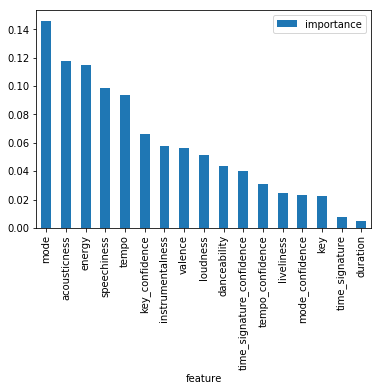

In [1256]:
importances.plot.bar()

In [1257]:
thresholds = sort(rfc_original.feature_importances_)
thresholds

array([0.00477804, 0.00745449, 0.02265241, 0.02348986, 0.02476794,
       0.03100638, 0.04022876, 0.04353131, 0.05115062, 0.05608149,
       0.05762294, 0.06605676, 0.09392558, 0.0984166 , 0.11500216,
       0.11781599, 0.14601866])

In [1258]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [1259]:
for threshold in thresholds:
    sfm = SelectFromModel(rfc, threshold=threshold, prefit=True)
    select_X_train = sfm.transform(X_train)
    rfc_new = RandomForestClassifier()
    rfc_new.fit(select_X_train, y_train)
    select_X_test = sfm.transform(X_test)
    predictions = rfc_new.predict(select_X_test)
    accuracy_score(y_test, predictions)
    print('current threshold: ', threshold)
    print('how many features: ', select_X_train.shape[1])
    print('accuracy score: ', np.round(accuracy_score(y_test, predictions), decimals=4))
    print('---')

current threshold:  0.004778039426286788
how many features:  16
accuracy score:  0.8444
---
current threshold:  0.00745448931965851
how many features:  15
accuracy score:  0.8428
---
current threshold:  0.02265240687353175
how many features:  14
accuracy score:  0.8367
---
current threshold:  0.023489863769816134
how many features:  14
accuracy score:  0.8461
---
current threshold:  0.024767941265605626
how many features:  14
accuracy score:  0.8411
---
current threshold:  0.0310063783604686
how many features:  13
accuracy score:  0.8489
---
current threshold:  0.04022876088242904
how many features:  11
accuracy score:  0.8456
---
current threshold:  0.04353130757851372
how many features:  8
accuracy score:  0.8344
---
current threshold:  0.05115061722690144
how many features:  8
accuracy score:  0.8411
---
current threshold:  0.05608149222493676
how many features:  7
accuracy score:  0.8311
---
current threshold:  0.057622944575312994
how many features:  7
accuracy score:  0.8222
---


/Users/Steve/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/base.py:80: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)


ValueError: Found array with 0 feature(s) (shape=(4200, 0)) while a minimum of 1 is required.

In [1260]:
sfm_test = SelectFromModel(rfc) #threshold with highest accuracy score
sfm_test.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
        norm_order=1, prefit=False, threshold=None)

In [1261]:
for feature_list_index in sfm_test.get_support(indices=True):
    print(df_features.columns[feature_list_index])

energy
tempo
speechiness
acousticness
instrumentalness
loudness
valence
mode


### Analysis:
In general, accuracy score stays relatively consistent as features decrease. It seems the best accuracy is around 10 - 15 features, going down in accuracy significantly from 4 features and below, with 'time_signature' and 'duration' being the least important. 
`SelectFromModel` chooses the top 9 features in order of importance:  'acousticness', 'speechiness', 'mode', 'energy', 'tempo', 'instrumentalness', 'key_confidence', loudness', and 'valence'. 

### RFC - RFE

In [1262]:
from sklearn.feature_selection import RFE

In [1263]:
rfc_rfe = RandomForestClassifier()

In [1264]:
rfe_model = RFE(rfc_rfe, n_features_to_select=9)

In [1265]:
rfe_model = rfe_model.fit(X_train, y_train)

In [1266]:
print(rfe_model.support_)


[False  True False  True  True  True  True False False  True  True False
  True False False  True False]


In [1267]:
print(rfe_model.ranking_)
print(df_features.columns)

[7 1 4 1 1 1 1 8 9 1 1 2 1 3 5 1 6]
Index(['key', 'energy', 'liveliness', 'tempo', 'speechiness', 'acousticness',
       'instrumentalness', 'time_signature', 'duration', 'loudness', 'valence',
       'danceability', 'mode', 'time_signature_confidence', 'tempo_confidence',
       'key_confidence', 'mode_confidence'],
      dtype='object')


In [1268]:
rfe_predictions = rfe_model.predict(X_test)

In [1269]:
print(accuracy_score(y_test, rfe_predictions))

0.84


In [1270]:
# testing 5 features
rfe_model_5 = RFE(rfc_rfe, n_features_to_select=5)
rfe_model_5 = rfe_model.fit(X_train, y_train)
print(rfe_model_5.support_)
print(rfe_model_5.ranking_)
print(df_features.columns)
rfe_predictions_5 = rfe_model_5.predict(X_test)
print(accuracy_score(y_test, rfe_predictions_5))

[False  True False  True  True  True  True False False  True  True False
  True False False  True False]
[7 1 4 1 1 1 1 8 9 1 1 2 1 3 5 1 6]
Index(['key', 'energy', 'liveliness', 'tempo', 'speechiness', 'acousticness',
       'instrumentalness', 'time_signature', 'duration', 'loudness', 'valence',
       'danceability', 'mode', 'time_signature_confidence', 'tempo_confidence',
       'key_confidence', 'mode_confidence'],
      dtype='object')
0.8422222222222222


## RFC Optimized

In [1271]:
rfc_optimized = RandomForestClassifier(n_estimators=100, min_samples_split=4, max_features='sqrt')

In [1272]:
rfc_selector = SelectFromModel(rfc_optimized)
X_new_rfc = rfc_selector.fit_transform(X, y)

In [1273]:
X_new_rfc.shape

(6000, 6)

In [1274]:
df_features.columns[rfc_selector.get_support(indices=True)].tolist()

['energy', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'mode']

In [1275]:
X = X_new_rfc
y = df_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [1276]:
rfc_optimized.fit(X_train, y_train)
rfc_op_predictions = rfc_optimized.predict(X_test)
np.round(accuracy_score(y_test, rfc_op_predictions), decimals=3)
print(confusion_matrix(y_test, rfc_op_predictions))
print('----------------------')
print(classification_report(list(y_test), list(rfc_op_predictions)))

[[366  10  35  26]
 [ 12 411   7  25]
 [ 39   9 392  15]
 [ 29  48  10 366]]
----------------------
             precision    recall  f1-score   support

      dance       0.82      0.84      0.83       437
       jazz       0.86      0.90      0.88       455
        rap       0.88      0.86      0.87       455
       rock       0.85      0.81      0.83       453

avg / total       0.85      0.85      0.85      1800



## Analysis: 
    Random Forest Classifer — best and optimized yield similar accuracy score, because the accuracy is pretty consistent throughout the top 9-14 features with around 85 - 86% accuracy. But both are significantly better than the original RFC classifier.  

# LOGISTIC REGRESSION

In [1277]:
from sklearn.linear_model import LogisticRegression

### Original

In [1278]:
logreg = LogisticRegression()
LR_original = LogisticRegression(solver='saga', multi_class='multinomial')

In [1279]:
X = df_features_final
y = df_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [1280]:
LR_original = LR_original.fit(X_train, y_train)

In [1281]:
LR_og_pred = LR_original.predict(X_test)

In [1282]:
print(confusion_matrix(y_test, LR_og_pred))
print('----------------------')
print(classification_report(list(y_test), list(LR_og_pred)))

[[321  11  56  49]
 [ 17 393  13  32]
 [ 64  16 356  19]
 [ 42  56  18 337]]
----------------------
             precision    recall  f1-score   support

      dance       0.72      0.73      0.73       437
       jazz       0.83      0.86      0.84       455
        rap       0.80      0.78      0.79       455
       rock       0.77      0.74      0.76       453

avg / total       0.78      0.78      0.78      1800



# LR - Grid Search CV

In [1283]:
LR_param_grid = {'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'], 'multi_class': ['ovr', 'multinomial']}

In [1284]:
LR_grid = GridSearchCV(logreg, LR_param_grid, verbose=3)

In [1285]:
LR_grid.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] multi_class=ovr, solver=newton-cg ...............................
[CV]  multi_class=ovr, solver=newton-cg, score=0.7781740370898717, total=   0.1s
[CV] multi_class=ovr, solver=newton-cg ...............................
[CV]  multi_class=ovr, solver=newton-cg, score=0.7412437455325233, total=   0.1s
[CV] multi_class=ovr, solver=newton-cg ...............................
[CV]  multi_class=ovr, solver=newton-cg, score=0.7684060042887777, total=   0.1s
[CV] multi_class=ovr, solver=sag .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  multi_class=ovr, solver=sag, score=0.7781740370898717, total=   0.1s
[CV] multi_class=ovr, solver=sag .....................................
[CV]  multi_class=ovr, solver=sag, score=0.7412437455325233, total=   0.1s
[CV] multi_class=ovr, solver=sag .....................................
[CV]  multi_class=ovr, solver=sag, score=0.7684060042887777, total=   0.1s
[CV] multi_class=ovr, solver=saga ....................................
[CV]  multi_class=ovr, solver=saga, score=0.7781740370898717, total=   0.1s
[CV] multi_class=ovr, solver=saga ....................................
[CV]  multi_class=ovr, solver=saga, score=0.7412437455325233, total=   0.1s
[CV] multi_class=ovr, solver=saga ....................................
[CV]  multi_class=ovr, solver=saga, score=0.7684060042887777, total=   0.1s
[CV] multi_class=ovr, solver=lbfgs ...................................
[CV]  multi_class=ovr, solver=lbfgs, score=0.7781740370898717, total=   0.0s
[CV] multi_class=ovr, solver=lbfgs .........

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    1.6s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'], 'multi_class': ['ovr', 'multinomial']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [1286]:
LR_grid.best_params_

{'multi_class': 'ovr', 'solver': 'newton-cg'}

### Logistic Regression - Best

In [1287]:
LR_best = LogisticRegression(solver='newton-cg', multi_class='multinomial')
LR_best.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [1288]:
LR_best_pred = LR_best.predict(X_test)

In [1289]:
np.round(accuracy_score(y_test, LR_best_pred), decimals=3)

0.782

In [1290]:
print(confusion_matrix(y_test, LR_best_pred))
print(classification_report(list(y_test), list(LR_best_pred)))

[[321  11  56  49]
 [ 17 393  13  32]
 [ 64  16 356  19]
 [ 42  56  18 337]]
             precision    recall  f1-score   support

      dance       0.72      0.73      0.73       437
       jazz       0.83      0.86      0.84       455
        rap       0.80      0.78      0.79       455
       rock       0.77      0.74      0.76       453

avg / total       0.78      0.78      0.78      1800



### Selecting Best Features

In [1291]:
logreg_selector = SelectFromModel(LR_original, prefit=True)

In [1292]:
X_new_logreg = logreg_selector.transform(X)

In [1293]:
X_new_logreg.shape

(6000, 7)

In [1294]:
df_features.columns[logreg_selector.get_support(indices=True)].tolist()

['energy',
 'speechiness',
 'acousticness',
 'valence',
 'danceability',
 'mode',
 'key_confidence']

### LR - RFE

In [1295]:
rfe_lr = RFE(logreg, n_features_to_select=5)

In [1296]:
rfe_lr = rfe_lr.fit(X_train, y_train)

In [1297]:
print(rfe_lr.support_)


[False  True False False  True  True  True False False False False False
  True False False False False]


In [1298]:
print(rfe_lr.ranking_)
print(df_features.columns)

[13  1 11  7  1  1  1  8 12  4  5  3  1  6 10  2  9]
Index(['key', 'energy', 'liveliness', 'tempo', 'speechiness', 'acousticness',
       'instrumentalness', 'time_signature', 'duration', 'loudness', 'valence',
       'danceability', 'mode', 'time_signature_confidence', 'tempo_confidence',
       'key_confidence', 'mode_confidence'],
      dtype='object')


In [1299]:
rfe_logreg_predictions = rfe_lr.predict(X_test)

In [1300]:
print(accuracy_score(y_test, rfe_logreg_predictions))

0.7305555555555555


## Logistic Regression Optimized

In [1301]:
logreg_optimized = LogisticRegression(solver='newton-cg', multi_class='multinomial')

In [1302]:
X = X_new_logreg
y = df_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [1303]:
logreg_optimized.fit(X_train, y_train)
logreg_op_pred = logreg_optimized.predict(X_test)
print('accuracy score: ', np.round(accuracy_score(y_test, logreg_op_pred), decimals=3))
print(confusion_matrix(y_test, logreg_op_pred))
print('---------------------')
print(classification_report(list(y_test), list(logreg_op_pred)))

accuracy score:  0.745
[[320   9  64  44]
 [ 11 383  13  48]
 [ 75  15 337  28]
 [ 60  79  13 301]]
---------------------
             precision    recall  f1-score   support

      dance       0.69      0.73      0.71       437
       jazz       0.79      0.84      0.81       455
        rap       0.79      0.74      0.76       455
       rock       0.71      0.66      0.69       453

avg / total       0.75      0.74      0.74      1800



# Analysis: Logistic Regression

Logistic regression original performed best with 78% accuracy. After best params were determined, accuracy went down. SelectFromModel method on Logistic Regression returned the top 57 features as 'energy', 'speechiness', 'acousticness', 'danceability', 'valence', 'key_confidence', 'mode'. When these features alone were used, accuracy was only 73%, probably because it was not big enough. 